# Housing Sales Prices & Venues Data Analysis of Mexico City

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## Introduction: Business Problem <a name="introduction"></a>

The aim of this project is to build a tool that disclose the price and venues from the different Neighbourhoods that conform **Mexico City**.Specifically, this report will be target to **citizens that look for real estate properties with the correct price and amenities in the vicinity** just as gym, restaurants, supermarkets etc. 
Moreover, it will **help investors to make business decisions**, since the tool will give them information such as the **average square meter price** of the different boroughs, the **most common venues** in the zone and what business are more likely to suceed. 

We will use our data science powers to generate a few most promissing neighborhoods based on this criteria. Advantages of each area will then be clearly expressed so that best possible final location can be chosen by stakeholders.

## Data <a name="data"></a>

Based on definition of our problem, factors that will drive stakeholders decisions are:
* Type of venues in the vicinity of the different Boroughs. 
* Average square meter price of the different places.
* Distance of neighborhood from city center

We decided to use regularly spaced grid of locations, centered around city center, to define our neighborhoods.

Following data sources will be needed to extract/generate the required information:
* Venues type and location in every neighborhood will be obtained using **Foursquare API**
* Average square meter price will be obtained from **metroscuadrados** a real estate retailer in Mexico.
* The coordinates of the different Neighborhoods and Boroughs will be obtained from **Mexico City Government website** as a geojson file.

### Neighborhood Candidates

First we are going to import all the libraries need it for the capstone Project.
* Pandas and Numpy to work with Dataframes.
* Matplot and seaborn to work with graphs.
* Json to work with Json files
* geopy and folium to work with maps
* sklearn and yellowbrick to work and to evaluate the Machine Learning algorithms.

In [1]:
! pip install xlrd
%matplotlib inline 
from scipy.stats import poisson
!conda install -c districtdatalabs yellowbrick --yes
import matplotlib.pyplot as plt
import seaborn as sns 
from yellowbrick.cluster import KElbowVisualizer
import numpy as np
import pandas as pd
import json # library to handle JSON files

!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes 
import folium # map rendering library

#!pip install --upgrade matplotlib

print('Libraries imported.')

     |████████████████████████████████| 112kB 28.3MB/s eta 0:00:01
Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.11
  latest version: 4.8.2

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs: 
    - yellowbrick


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    matplotlib-2.2.2           |   py36hb69df0a_2         6.6 MB
    pytest-5.3.5               |           py36_0         380 KB
    openssl-1.1.1d             |       h7b6447c_4         3.7 MB
    py-1.8.1                   |             py_0          69 KB
    pytest-runner-5.2          |             py_0          13 KB
    yellowbrick-1.0.1          |           py36_0         429 KB  districtdatalabs
    packaging-20.1             |             p

### Retrieve the information of Boroughs and Average Price 

The dataframe df has the information of the average price in the different Boroughs, whereas df2 has the information of the latitudes and longitudes of the Boroughs

In [286]:
df=pd.read_excel('Borough information.xlsx')  
df.replace({'Borough':{'Alvaro Obregón':'Álvaro Obregón', 'Cuauthémoc':'Cuauhtémoc', 'Gustavo A Madero':'Gustavo A. Madero','Tlahuác':'Tláhuac'}},inplace =True)
df2=pd.read_excel('Alcaldias.xlsx')
df['Average Square Meter']=df.mean(axis=1)

In [287]:
df.head()

,Borough,House Alone,Department,House Condominium,Average Square Meter
0,Álvaro Obregón,26003.00,31371.95,25878.55,27751.166667
1,Azcapotzalco,12688.96,17036.16,14084.18,14603.100000
2,Benito Juárez,25097.83,29594.46,25611.02,26767.770000
3,Coyoacán,20755.53,24808.50,23481.23,23015.086667
4,Cuajimalpa de Morelos,26128.21,36919.30,25100.27,29382.593333


In [288]:
df2.head()

,NOMBRE,CLAVE_MUNICIPAL,CVE_ENTIDAD,CVEGEO,Geo Point,Geo Shape
0,Cuauhtémoc,15,9,9015,"19.4313734294, -99.1490557562","{""type"": ""Polygon"", ""coordinates"": [[[-99.1291..."
1,Álvaro Obregón,10,9,9010,"19.336175562, -99.246819712","{""type"": ""Polygon"", ""coordinates"": [[[-99.1887..."
2,Xochimilco,13,9,9013,"19.2451450458, -99.0903636045","{""type"": ""Polygon"", ""coordinates"": [[[-99.0986..."
3,Tláhuac,11,9,9011,"19.2769983772, -99.0028216137","{""type"": ""Polygon"", ""coordinates"": [[[-98.9789..."
4,Benito Juárez,14,9,9014,"19.3806424162, -99.1611346584","{""type"": ""Polygon"", ""coordinates"": [[[-99.1367..."


### Join the information of Boroughs(Government df) and Average Square price ( Metroscubicos df)

The join of the dataframes df and df2 will be named Mexicodf, it will be form of Borough, the different types of housing, the average price of the three, the key by borough (alc), the latitude and the longitude in the center of each borough.

In [289]:
Mexicodf=df.merge(df2[['NOMBRE','Geo Point','CLAVE_MUNICIPAL']], left_on='Borough',right_on='NOMBRE')
new = Mexicodf["Geo Point"].str.split(',', n = 1, expand = True) 
Mexicodf['Latitud']=new[0]
Mexicodf['Longitud']=new[1]
Mexicodf.drop(['NOMBRE','Geo Point'], axis=1,inplace= True)
Mexicodf.rename(columns={'CLAVE_MUNICIPAL':'Alc'},inplace= True)
Mexicodf= Mexicodf.astype({'Latitud':np.float64,'Longitud':np.float64})
w=Mexicodf
Mexicodf.head()


,Borough,House Alone,Department,House Condominium,Average Square Meter,Alc,Latitud,Longitud
0,Álvaro Obregón,26003.00,31371.95,25878.55,27751.166667,10,19.336176,-99.246820
1,Azcapotzalco,12688.96,17036.16,14084.18,14603.100000,2,19.485329,-99.182107
2,Benito Juárez,25097.83,29594.46,25611.02,26767.770000,14,19.380642,-99.161135
3,Coyoacán,20755.53,24808.50,23481.23,23015.086667,3,19.326667,-99.150376
4,Cuajimalpa de Morelos,26128.21,36919.30,25100.27,29382.593333,4,19.324634,-99.310729


In [232]:
# @hidden_cell
#CLIENT_ID = 'FEA40311LOULQ5JAEDOAFGJDEPSDKDKJ1GJFQO5MAOICZ1JS' # your Foursquare ID
#CLIENT_SECRET = 'IQG2LLIT0DVNFJM0QRXOQ1FEMF1CVIEY1ZWACTC2PUYM5VRC' # your Foursquare Secret
#VERSION = '20180323' # Foursquare API version
LIMIT=100

In [233]:
# @hidden_cell 
#2da cuenta de Foursquare
CLIENT_ID = 'XUO5CNTCB2ROQYPSESTMU2OLDMMARYMHODOKLB2Y3EGC0BYX' # your Foursquare ID
CLIENT_SECRET = 'ZGKSL3OSJG1W3MS1DQR0RPA4ETU3LVB2EYJNE2WBQ5FVBD3F' # your Foursquare Secret
VERSION = '20180323' # Foursquare API version
LIMIT=100

In [234]:
# @hidden_cell 
#3era cuenta de Foursquare
CLIENT_ID = 'JIXFU2LVGASHULG25CJKJGLWQJT53UAX1LILS5U1IEHEDDZI' # your Foursquare ID
CLIENT_SECRET = 'ZPC5R2PZY4OOCVGMSRO001X4QW55KNL2MLLDP4FUVX11QJ1Q' # your Foursquare Secret
VERSION = '20180323' # Foursquare API version
LIMIT=100


### Let's set the location to Mexico City

We are going to use the geopy library to retrieve the location of Mexico City

In [235]:
address = 'Mexico City, MX'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Mexico City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Mexico City are 19.4326296, -99.1331785.


## Let's create the Map of the Boroughs in Mexico City (16)

Beneath it will be created a Folium map, to show Mexico City with the centers of each Borough

In [236]:
# create map of New York using latitude and longitude values
map_CDMX = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough in zip(Mexicodf['Latitud'], Mexicodf['Longitud'], Mexicodf['Borough']):
    label = '{}'.format(borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_CDMX)  
    
map_CDMX

### Let's read the information of Neighborhoods (Government df)

Here we are reading the information of the Neighborhoods. Futhermore, the borough information will be updated to upper case and it will be replace the letters with accents. Finally the column COLONIA will be renamed to Neighborhood.

In [237]:
df3=pd.read_excel('Colonias.xlsx')  
Mexicodf['Borough'] = Mexicodf['Borough'].str.upper() 
Mexicodf.replace({'Borough':{'ÁLVARO OBREGÓN':'ALVARO OBREGON', 'BENITO JUÁREZ':'BENITO JUAREZ', 'COYOACÁN':'COYOACAN','TLÁHUAC':'TLAHUAC','CUAUHTÉMOC':'CUAUHTEMOC'}},inplace =True)
df3.rename(columns={'COLONIA':'Neighborhood'},inplace= True)
df3.head()

,Neighborhood,ENTIDAD,Geo Point,Geo Shape,CVE_ALC,ALCALDIA,CVE_COL,SECC_COM,SECC_PAR
0,IRRIGACION,9.0,"19.4429549298, -99.2099357048","{""type"": ""Polygon"", ""coordinates"": [[[-99.2115...",16,MIGUEL HIDALGO,16-035,"5079, 5080, 5083, 5102","5068, 5082"
1,MARINA NACIONAL (U HAB),9.0,"19.4466319056, -99.1795110575","{""type"": ""Polygon"", ""coordinates"": [[[-99.1797...",16,MIGUEL HIDALGO,16-049,"5137, 5182",NaN
2,PEDREGAL DE STO DOMINGO VI,9.0,"19.3234027183, -99.1654676133","{""type"": ""Polygon"", ""coordinates"": [[[-99.1622...",3,COYOACAN,03-144,"381, 394, 494, 416, 417, 439",NaN
3,VILLA PANAMERICANA 7MA. SECCIN (U HAB),9.0,"19.304604269, -99.1677617231","{""type"": ""Polygon"", ""coordinates"": [[[-99.1676...",3,COYOACAN,03-121,NaN,"474, 475"
4,VILLA PANAMERICANA 6TA. SECCIN (U HAB),9.0,"19.3112238873, -99.1696478642","{""type"": ""Polygon"", ""coordinates"": [[[-99.1702...",3,COYOACAN,03-120,NaN,458


### Let's join Boroughs and Neighborhoods information

Our main asset here it is created the dataframe CDMXdf is the merge of the information of the different Neighborhoods(df3) and the Boroughs (Mexicodf). Moreover,first it is renamed the columns Latitud and Longitud, second the content of the 'Geo Point' is splitted to form the Latitude and Longitude columns of the Neighborhoods.

In [238]:
CDMXdf=df3[['Neighborhood','Geo Point','ALCALDIA','CVE_ALC']].merge(Mexicodf[['Borough','Average Square Meter','Latitud','Longitud']], left_on='ALCALDIA',right_on='Borough')
new = CDMXdf["Geo Point"].str.split(',', n = 1, expand = True) 
CDMXdf.rename({'Latitud': "Lat Center", 'Longitud': "Lon Center"},axis=1,inplace= True)
CDMXdf['Latitude']=new[0]
CDMXdf['Longitude']=new[1]
CDMXdf.drop(['ALCALDIA','Geo Point'], axis=1,inplace= True)
CDMXdf['CVE_ALC']=CDMXdf['CVE_ALC']-1
CDMXdf.head()

,Neighborhood,CVE_ALC,Borough,Average Square Meter,Lat Center,Lon Center,Latitude,Longitude
0,IRRIGACION,15,MIGUEL HIDALGO,40772.71,19.428062,-99.204567,19.4429549298,-99.2099357048
1,MARINA NACIONAL (U HAB),15,MIGUEL HIDALGO,40772.71,19.428062,-99.204567,19.4466319056,-99.1795110575
2,MORALES SECCION ALAMEDA (POLANCO),15,MIGUEL HIDALGO,40772.71,19.428062,-99.204567,19.4337174017,-99.2048231931
3,TORRE BLANCA (AMPL),15,MIGUEL HIDALGO,40772.71,19.428062,-99.204567,19.454722061,-99.1998072368
4,ARGENTINA ANTIGUA,15,MIGUEL HIDALGO,40772.71,19.428062,-99.204567,19.4555189573,-99.2070212923


In [239]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(CDMXdf['Borough'].unique()),
        CDMXdf.shape[0]
    )
)

The dataframe has 16 boroughs and 1812 neighborhoods.


In [240]:
CDMXdf= CDMXdf.astype({'Borough':str})

### Let's make a sample of 1300 Neighborhoods and do a group by

Here we take a sample of 1300 Neighborhoods, to build a folium map of the different neighborhoods (colored by each Borough).

In [241]:
CDMXdf= CDMXdf.astype({'Latitude':np.float32,'Longitude':np.float32})
CDMXdf=CDMXdf[CDMXdf.Longitude.notnull()]
CDMXdf2=CDMXdf.sample(1300)
CDMXdf2

,Neighborhood,CVE_ALC,Borough,Average Square Meter,Lat Center,Lon Center,Latitude,Longitude
1047,SANTA MARIA LA RIBERA II,14,CUAUHTEMOC,25924.263333,19.431373,-99.149056,19.449219,-99.158508
1179,PRIVADA CENTENARIO,9,ALVARO OBREGON,27751.166667,19.336176,-99.246820,19.361359,-99.229675
1545,BARRANCAS DE GUADALUPE,6,IZTAPALAPA,12117.383333,19.349166,-99.056799,19.327421,-99.022995
1563,JOSE LOPEZ PORTILLO II,6,IZTAPALAPA,12117.383333,19.349166,-99.056799,19.308125,-99.080414
1441,SAN JUAN XALPA I,6,IZTAPALAPA,12117.383333,19.349166,-99.056799,19.337420,-99.083458
...,...,...,...,...,...,...,...,...
40,TORRES TOREO,15,MIGUEL HIDALGO,40772.710000,19.428062,-99.204567,19.458384,-99.212410
705,SN JUAN TEPEXIMILPA (AMPL),11,TLALPAN,20450.886667,19.198340,-99.206221,19.272696,-99.192841
1460,"EJTO CONSTITUCIONALISTA, SUPERMANZANA II ( U HAB)",6,IZTAPALAPA,12117.383333,19.349166,-99.056799,19.386478,-99.056778
1200,TORRES SAN ANTONIO (U HAB),9,ALVARO OBREGON,27751.166667,19.336176,-99.246820,19.385111,-99.194481


Here we make a groupby of the CDMXdf2 dataframe in order to analyze the distribution of Neighborhoods by each borough

In [242]:
a=CDMXdf2[['Borough','Neighborhood']].groupby('Borough').count()
a

,Neighborhood
Borough,
ALVARO OBREGON,165
AZCAPOTZALCO,81
BENITO JUAREZ,45
COYOACAN,121
CUAJIMALPA DE MORELOS,27
CUAUHTEMOC,54
GUSTAVO A. MADERO,165
IZTACALCO,34
IZTAPALAPA,217


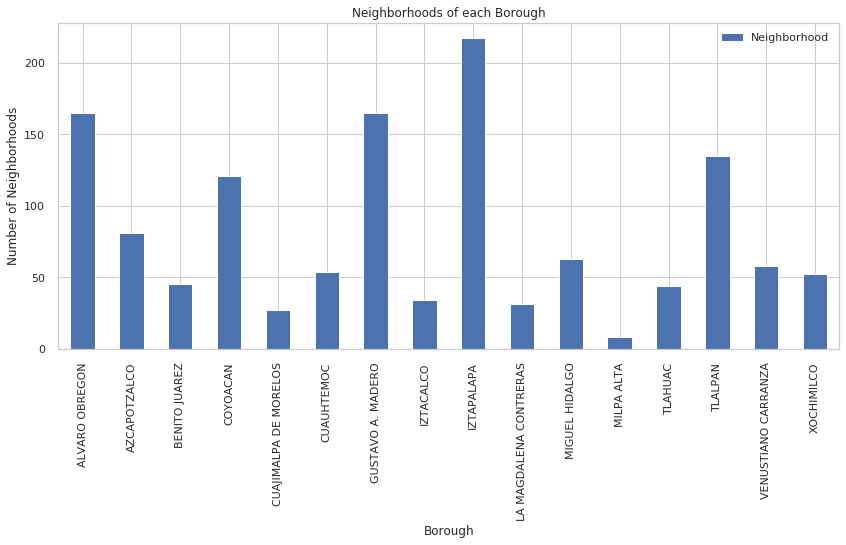

In [243]:
a.plot(kind='bar', figsize=(14, 6))

plt.xlabel('Borough') # add to x-label to the plot
plt.ylabel('Number of Neighborhoods') # add y-label to the plot
plt.title('Neighborhoods of each Borough') # add title to the plot

plt.show()

## Let's create the Map of the Neighborhoods in Mexico City a sample of 1300/1812

In [245]:
# create map of New York using latitude and longitude values
Borough=16
map_CDMX = folium.Map(location=[latitude, longitude], zoom_start=10)
x = np.arange(Borough)
ys = [i + x + (i*x)**2 for i in range(Borough)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
i=0
for lat, lng, borough, neighborhood,col in zip(CDMXdf2['Latitude'], CDMXdf2['Longitude'], CDMXdf2['Borough'], CDMXdf2['Neighborhood'],CDMXdf2['CVE_ALC']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        popup=label,
        color=rainbow[col-1],
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_CDMX)  
    
map_CDMX

### Let's retrieve the nearby venues to each Neighborhood Sample 225/1800

In [246]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        i=1    
        print(i,name)
        i=1+i      
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()['response']['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [ ]:
MH_data=CDMXdf.sample(225)
#MH_data = CDMXdf[CDMXdf['Borough'] == 'BENITO JUAREZ'].reset_index(drop=True)
#MH_data.drop([1,2],axis=0,inplace= True )
#MH_data= MH_data.astype({'Latitude':str,'Longitude':str})
MH_data.head()


In [247]:
MH_data.shape

(225, 8)

In [249]:
CDMX_venues = getNearbyVenues(names=MH_data['Neighborhood'],
                                   latitudes=MH_data['Latitude'],
                                   longitudes=MH_data['Longitude']
                                  )



1 TECACALANCO
1 EL PIRU (FRACC)
1 ARTES GRAFICAS
1 SAN LORENZO LA CEBADA II
1 LA ANGOSTURA
1 SAN JOSE BUENAVISTA
1 LOPEZ PORTILLO
1 SOLIDARIDAD NACIONAL
1 LOMAS HIDALGO
1 CASAS ALEMAN (AMPL) I
1 SANTA URSULA XITLA
1 BELEM (BARR)
1 DEL NIO JESUS (BARR)
1 SAN FRANCISCO TECOXPA (PBLO)
1 MANZANASTITLA
1 GENERAL FELIPE BERRIOZABAL
1 REYNOSA TAMAULIPAS
1 ESTRELLA
1 SAN ANDRES (PBLO)
1 CAPULTITLAN
1 HUASIPUNGO (U HAB)
1 ANGEL ZIMBRON
1 AMPLIACION RAMOS MILLAN
1 POLANCO REFORMA (POLANCO)
1 LA VIRGEN 1170 (U HAB)
1 SAN MARCOS (BARR)
1 EMILIANO ZAPATA (AMPL)
1 JARDINES DEL SUR
1 LOMAS DE SANTO DOMINGO (AMPL)
1 SANTA MARTHA ACATITLA_(PBLO)
1 PANTITLAN I
1 2A AMPLIACION SANTIAGO ACAHUALTEPEC I
1 FLOR DE MARIA
1 SAN JUAN DE ARAGON 6A SECCION (U HAB) II
1 CACAMA
1 SAN MIGUEL CHAPULTEPEC I
1 ORIENTE (AMPL)
1 EJTO CONSTITUCIONALISTA
1 LIBERTAD
1 BELLAVISTA (U HAB)
1 ALTOS TEPETLICA
1 EJIDOS SAN JUAN DE ARAGON 1A SECCION (U HAB)
1 ARVIDE
1 MAGDALENA  MIXHUCA (PBLO)
1 GUADALUPE TEPEYAC
1 PEDREGAL 2 (CON

### The Venues Dataframe are 7 columns and 4254 different venues retrieve in the 225 Neighborhood sample.

In [250]:
print(CDMX_venues.shape)
CDMX_venues.head()

(4718, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,EL PIRU (FRACC),19.380379,-99.217964,Feli Pizzas,19.380835,-99.214226,Pizza Place
1,EL PIRU (FRACC),19.380379,-99.217964,Taqueria El Guero,19.377413,-99.219273,Taco Place
2,EL PIRU (FRACC),19.380379,-99.217964,Alitas Bbq,19.378107,-99.217899,Wings Joint
3,EL PIRU (FRACC),19.380379,-99.217964,Mercado De Los Domingos (Capula),19.379685,-99.215438,Market
4,ARTES GRAFICAS,19.411346,-99.125870,El Huarache De Jamaica,19.409581,-99.124144,Mexican Restaurant


## Methodology <a name="methodology"></a>

In this project we are going to work with a sample of 12.5% neighborhoods of the Mexico City (225 of 1800). The main reason is the limit of calls that the Foursquare API set us. 
Firstof all, we have retrieve the venues in a range of 500 m from center of each Neighborhood and limit to 100 calls per Neighborhood.

Second step in our analysis will be calculation of the top 10 most repeat it venues in each neighborhood,after it will transform with dummies values in order to train the Machine Learning model. Subsequently, the dataframe of the Dummies of the top 10 venues per neighborhood will be our raw material to evaluate which k is the best to train our model with the Elbow methodology.

In third step we are going to establish a Type Zone base on the average price of square meter for each Borough and the Cluster name base on the type of venues that form it.
Finally, it will be build graphs of distribution of the average house price to establish the limits and two maps: one with the cluster information only, and other a choropleth map of Mexico City, that color the city base on the average price of the square meter in each Neighborhood and it is label with the information of the Price zone type, the Cluster name, the top 3 venues of the neighborhood and the name of the Neighborhood.

## Analysis <a name="analysis"></a>

Let's perform some basic explanatory data analysis and derive some additional info from our raw data. First let's count the number of venues in every Borough,and build a bar graph for each Borough.

### Let's see the distribution of Venues among the Boroughs

In [251]:
a=CDMX_venues.merge(CDMXdf[['Borough','Neighborhood']], left_on='Neighborhood',right_on='Neighborhood')
a=a[['Borough','Venue']].groupby('Borough').count()
a

,Venue
Borough,
ALVARO OBREGON,527
AZCAPOTZALCO,379
BENITO JUAREZ,682
COYOACAN,615
CUAJIMALPA DE MORELOS,46
CUAUHTEMOC,391
GUSTAVO A. MADERO,550
IZTACALCO,121
IZTAPALAPA,545


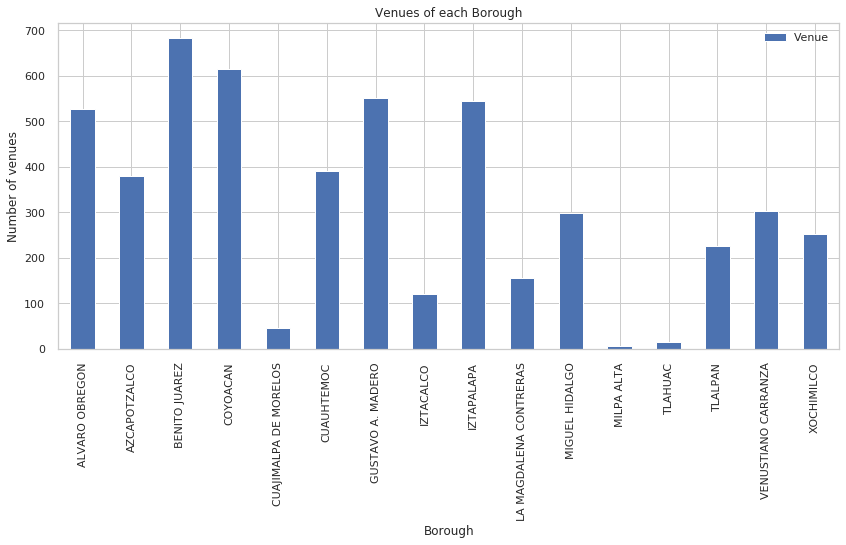

In [252]:
a.plot(kind='bar', figsize=(14, 6))

plt.xlabel('Borough') # add to x-label to the plot
plt.ylabel('Number of venues') # add y-label to the plot
plt.title('Venues of each Borough') # add title to the plot

plt.show()

In [253]:
print('There are {} uniques categories.'.format(len(CDMX_venues['Venue Category'].unique())))

There are 308 uniques categories.


### Let's get the dummies and prepare the information to cluster it

Now we now that there are 309 unique categories and we are going to set the dummies for each Neighborhood if the Venues that are in the zone.

In [254]:
# one hot encoding
CDMX_onehot = pd.get_dummies(CDMX_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
CDMX_onehot['Neighborhood'] = CDMX_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [CDMX_onehot.columns[-1]] + list(CDMX_onehot.columns[:-1])
CDMX_onehot = CDMX_onehot[fixed_columns]

CDMX_onehot.head()

,Zoo,ATM,Accessories Store,African Restaurant,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,...,Warehouse Store,Water Park,Waterfall,Whisky Bar,Wine Bar,Winery,Wings Joint,Women's Store,Yoga Studio,Yucatecan Restaurant
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [255]:
CDMX_onehot.shape

(4718, 308)

Here we group the dataframe by Neighborhood taking the mean that each venue appears in the zone.

In [256]:
CDMX_grouped = CDMX_onehot.groupby('Neighborhood').mean().reset_index()
CDMX_grouped.head()

,Neighborhood,Zoo,ATM,Accessories Store,African Restaurant,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,...,Warehouse Store,Water Park,Waterfall,Whisky Bar,Wine Bar,Winery,Wings Joint,Women's Store,Yoga Studio,Yucatecan Restaurant
0,2A AMPLIACION SANTIAGO ACAHUALTEPEC I,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2A AMPLIACION SANTIAGO ACAHUALTEPEC II,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,6 DE JUNIO,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,7 DE JULIO,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,ABRAHAM GONZALEZ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [257]:
CDMX_grouped.shape

(221, 308)

Finally we are going to retrieve the top 10 most common places for each Borough

In [258]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

### Let's retrieve the 10 most common places

In [259]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = CDMX_grouped['Neighborhood']

for ind in np.arange(CDMX_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(CDMX_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,2A AMPLIACION SANTIAGO ACAHUALTEPEC I,Bar,Skate Park,Seafood Restaurant,Gym,BBQ Joint,Pharmacy,Fast Food Restaurant,Sandwich Place,Taco Place,Chinese Restaurant
1,2A AMPLIACION SANTIAGO ACAHUALTEPEC II,Convenience Store,Soccer Stadium,Shopping Mall,Gym,Coffee Shop,Taco Place,Health & Beauty Service,Farmers Market,Burger Joint,Fast Food Restaurant
2,6 DE JUNIO,Moving Target,Shopping Mall,Food Truck,Park,Farm,Event Service,Event Space,Exhibit,Fabric Shop,Factory
3,7 DE JULIO,Pizza Place,Restaurant,Café,BBQ Joint,Diner,Rental Car Location,Coffee Shop,Donut Shop,Salad Place,Empanada Restaurant
4,ABRAHAM GONZALEZ,Mexican Restaurant,Taco Place,Burger Joint,Farmers Market,Bar,Restaurant,General Entertainment,Flea Market,Food Truck,Housing Development


### Let's measure which k is the best to cluster with the Elbow Method

Using as asset the Dataframe with the top 10 venues we are going to evaluate which k is the best to train our model.

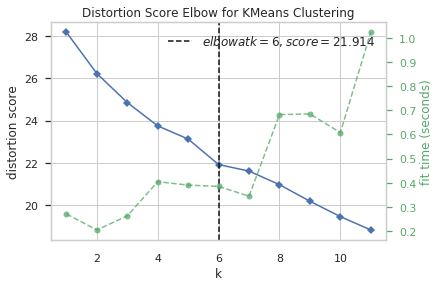

In [260]:
CDMX_grouped_clustering = CDMX_grouped.drop('Neighborhood', 1)
# Generate synthetic dataset with 8 random clusters
X=CDMX_grouped_clustering

# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,12))

visualizer.fit(X)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

### Let's make the Clusters

We can see that the best k is **6**. Thus the model is trained with 6 clusters.

In [261]:
# set number of clusters
kclusters = 6

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(CDMX_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([2, 2, 0, 2, 2, 2, 2, 2, 2, 2], dtype=int32)

In [262]:
neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,2A AMPLIACION SANTIAGO ACAHUALTEPEC I,Bar,Skate Park,Seafood Restaurant,Gym,BBQ Joint,Pharmacy,Fast Food Restaurant,Sandwich Place,Taco Place,Chinese Restaurant
1,2A AMPLIACION SANTIAGO ACAHUALTEPEC II,Convenience Store,Soccer Stadium,Shopping Mall,Gym,Coffee Shop,Taco Place,Health & Beauty Service,Farmers Market,Burger Joint,Fast Food Restaurant
2,6 DE JUNIO,Moving Target,Shopping Mall,Food Truck,Park,Farm,Event Service,Event Space,Exhibit,Fabric Shop,Factory
3,7 DE JULIO,Pizza Place,Restaurant,Café,BBQ Joint,Diner,Rental Car Location,Coffee Shop,Donut Shop,Salad Place,Empanada Restaurant
4,ABRAHAM GONZALEZ,Mexican Restaurant,Taco Place,Burger Joint,Farmers Market,Bar,Restaurant,General Entertainment,Flea Market,Food Truck,Housing Development


We append the Clusters with each Neighborhood, and we drop the rows that do not have any venue.

In [263]:
#neighborhoods_venues_sorted.drop('Cluster Labels',axis=1, inplace=True)

In [264]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

CDMX_merged = MH_data

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
CDMX_merged = CDMX_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')
CDMX_merged.dropna(inplace=True)
CDMX_merged=CDMX_merged.astype({'Cluster Labels':int})
CDMX_merged.head() # check the last columns!


,Neighborhood,CVE_ALC,Borough,Average Square Meter,Lat Center,Lon Center,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1171,EL PIRU (FRACC),9,ALVARO OBREGON,27751.166667,19.336176,-99.246820,19.380379,-99.217964,3,Taco Place,Wings Joint,Market,Pizza Place,Farmers Market,Event Service,Event Space,Exhibit,Fabric Shop,Factory
280,ARTES GRAFICAS,16,VENUSTIANO CARRANZA,11776.340000,19.430495,-99.093106,19.411346,-99.125870,2,Mexican Restaurant,Taco Place,Restaurant,Convenience Store,Farmers Market,Seafood Restaurant,Grocery Store,Bus Station,Boutique,Food Court
760,SAN LORENZO LA CEBADA II,12,XOCHIMILCO,15852.443333,19.245145,-99.090364,19.279520,-99.120590,2,Taco Place,Mexican Restaurant,Beer Garden,Pizza Place,BBQ Joint,Furniture / Home Store,Spa,Motel,Bike Rental / Bike Share,Fried Chicken Joint
1210,LA ANGOSTURA,9,ALVARO OBREGON,27751.166667,19.336176,-99.246820,19.333006,-99.232437,2,Convenience Store,Pizza Place,Garden,Asian Restaurant,Soccer Field,Taco Place,Stationery Store,Fish & Chips Shop,Film Studio,Fast Food Restaurant
1363,SAN JOSE BUENAVISTA,6,IZTAPALAPA,12117.383333,19.349166,-99.056799,19.320465,-99.034393,4,Movie Theater,Yucatecan Restaurant,Fast Food Restaurant,Event Service,Event Space,Exhibit,Fabric Shop,Factory,Farm,Farmers Market


In [265]:
#CDMX_merged= CDMX_merged.astype({'Latitude':np.float32,'Longitude':np.float32})

This is the first map of the clusters of the 225 Neighborhoods, each color is a different cluster.]

In [266]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=14)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
i=0
for lat, lon, poi, cluster in zip(CDMX_merged['Latitude'], CDMX_merged['Longitude'], CDMX_merged['Neighborhood'], CDMX_merged['Cluster Labels']):
    
    #i=i+1
    label = folium.Popup(str(poi) + ' Cluster' + str(cluster) , parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
    #if i==6:
        #break
map_clusters

This is the Histogram that show us clearly that there are more venues in the city in the Low range.

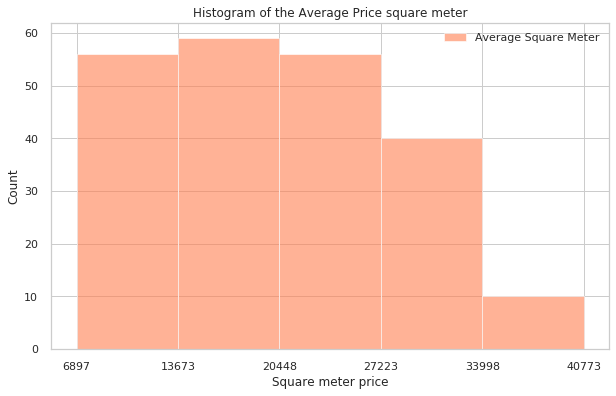

In [267]:
# let's get the x-tick values
count, bin_edges = np.histogram(CDMX_merged[['Average Square Meter']], 5)

# un-stacked histogram
CDMX_merged[['Average Square Meter']].plot(kind ='hist', 
          figsize=(10, 6),
          bins=5,
          alpha=0.6,
          xticks=bin_edges,
          color=['coral']
         )

plt.title('Histogram of the Average Price square meter')
plt.ylabel('Count')
plt.xlabel('Square meter price')

plt.show()

### Classify the Type of Zone and Type of Cluster

In [268]:
df = pd.DataFrame(columns=['Min_Range','Max_Range','Type of Zone'])
df.loc[0] = pd.Series({'Min_Range':6897, 'Max_Range':13673, 'Type of Zone':'Low Level HSP'})
df.loc[1] = pd.Series({'Min_Range':13673, 'Max_Range':20448, 'Type of Zone':'Bot Mid Level HSP'})
df.loc[2] = pd.Series({'Min_Range':20448, 'Max_Range':27223, 'Type of Zone':'Top Mid Level HSP'})
df.loc[3] = pd.Series({'Min_Range':27223, 'Max_Range':33998, 'Type of Zone':'High Level HSP'})
df.loc[4] = pd.Series({'Min_Range':33998, 'Max_Range':40773, 'Type of Zone':'Top Level HSP'})
df

,Min_Range,Max_Range,Type of Zone
0,6897,13673,Low Level HSP
1,13673,20448,Bot Mid Level HSP
2,20448,27223,Top Mid Level HSP
3,27223,33998,High Level HSP
4,33998,40773,Top Level HSP


We add the type of Housing Price Zone to the main  dataframe.

In [269]:
CDMX_merged.rename(columns={'Average Square Meter':'Average_Square_Meter'},inplace= True)
a = CDMX_merged.Average_Square_Meter.values
Max = df.Max_Range.values
Min = df.Min_Range.values

i, j = np.where((a[:, None] >= Min) & (a[:, None] <= Max))

CDMX_merged=pd.DataFrame(
    np.column_stack([CDMX_merged.values[i], df.values[j]]),
    columns=CDMX_merged.columns.append(df.columns)
)
CDMX_merged.drop(['Max_Range','Min_Range'], axis=1,inplace= True)
CDMX_merged.head()

,Neighborhood,CVE_ALC,Borough,Average_Square_Meter,Lat Center,Lon Center,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Type of Zone
0,EL PIRU (FRACC),9,ALVARO OBREGON,27751.2,19.3362,-99.2468,19.3804,-99.218,3,Taco Place,Wings Joint,Market,Pizza Place,Farmers Market,Event Service,Event Space,Exhibit,Fabric Shop,Factory,High Level HSP
1,ARTES GRAFICAS,16,VENUSTIANO CARRANZA,11776.3,19.4305,-99.0931,19.4113,-99.1259,2,Mexican Restaurant,Taco Place,Restaurant,Convenience Store,Farmers Market,Seafood Restaurant,Grocery Store,Bus Station,Boutique,Food Court,Low Level HSP
2,SAN LORENZO LA CEBADA II,12,XOCHIMILCO,15852.4,19.2451,-99.0904,19.2795,-99.1206,2,Taco Place,Mexican Restaurant,Beer Garden,Pizza Place,BBQ Joint,Furniture / Home Store,Spa,Motel,Bike Rental / Bike Share,Fried Chicken Joint,Bot Mid Level HSP
3,LA ANGOSTURA,9,ALVARO OBREGON,27751.2,19.3362,-99.2468,19.333,-99.2324,2,Convenience Store,Pizza Place,Garden,Asian Restaurant,Soccer Field,Taco Place,Stationery Store,Fish & Chips Shop,Film Studio,Fast Food Restaurant,High Level HSP
4,SAN JOSE BUENAVISTA,6,IZTAPALAPA,12117.4,19.3492,-99.0568,19.3205,-99.0344,4,Movie Theater,Yucatecan Restaurant,Fast Food Restaurant,Event Service,Event Space,Exhibit,Fabric Shop,Factory,Farm,Farmers Market,Low Level HSP


Here we join the top 3 most common venues per each Neighborhood.

In [270]:
CDMX_merged2=CDMX_merged
CDMX_merged['Join'] = CDMX_merged2[CDMX_merged2.columns[9:12]].apply(
    lambda x: ','.join(x.dropna().astype(str)),
    axis=1
)
CDMX_merged.head()

,Neighborhood,CVE_ALC,Borough,Average_Square_Meter,Lat Center,Lon Center,Latitude,Longitude,Cluster Labels,1st Most Common Venue,...,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Type of Zone,Join
0,EL PIRU (FRACC),9,ALVARO OBREGON,27751.2,19.3362,-99.2468,19.3804,-99.218,3,Taco Place,...,Market,Pizza Place,Farmers Market,Event Service,Event Space,Exhibit,Fabric Shop,Factory,High Level HSP,"Taco Place,Wings Joint,Market"
1,ARTES GRAFICAS,16,VENUSTIANO CARRANZA,11776.3,19.4305,-99.0931,19.4113,-99.1259,2,Mexican Restaurant,...,Restaurant,Convenience Store,Farmers Market,Seafood Restaurant,Grocery Store,Bus Station,Boutique,Food Court,Low Level HSP,"Mexican Restaurant,Taco Place,Restaurant"
2,SAN LORENZO LA CEBADA II,12,XOCHIMILCO,15852.4,19.2451,-99.0904,19.2795,-99.1206,2,Taco Place,...,Beer Garden,Pizza Place,BBQ Joint,Furniture / Home Store,Spa,Motel,Bike Rental / Bike Share,Fried Chicken Joint,Bot Mid Level HSP,"Taco Place,Mexican Restaurant,Beer Garden"
3,LA ANGOSTURA,9,ALVARO OBREGON,27751.2,19.3362,-99.2468,19.333,-99.2324,2,Convenience Store,...,Garden,Asian Restaurant,Soccer Field,Taco Place,Stationery Store,Fish & Chips Shop,Film Studio,Fast Food Restaurant,High Level HSP,"Convenience Store,Pizza Place,Garden"
4,SAN JOSE BUENAVISTA,6,IZTAPALAPA,12117.4,19.3492,-99.0568,19.3205,-99.0344,4,Movie Theater,...,Fast Food Restaurant,Event Service,Event Space,Exhibit,Fabric Shop,Factory,Farm,Farmers Market,Low Level HSP,"Movie Theater,Yucatecan Restaurant,Fast Food R..."


Here we show the composition of each cluster.

## cluster 1

In [271]:
CDMX_merged.loc[CDMX_merged['Cluster Labels'] == 0, CDMX_merged.columns[[0] + list(range(5, CDMX_merged.shape[1]))]].head()

,Neighborhood,Lon Center,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Type of Zone,Join
5,LOPEZ PORTILLO,-99.0028,19.309,-99.0209,0,Soccer Field,Pet Store,Yucatecan Restaurant,Farm,Event Service,Event Space,Exhibit,Fabric Shop,Factory,Farmers Market,Low Level HSP,"Soccer Field,Pet Store,Yucatecan Restaurant"
12,SAN FRANCISCO TECOXPA (PBLO),-99.0511,19.2004,-99.0026,0,Pool,Burger Joint,Soccer Field,Yucatecan Restaurant,Farmers Market,Event Service,Event Space,Exhibit,Fabric Shop,Factory,Low Level HSP,"Pool,Burger Joint,Soccer Field"
19,HUASIPUNGO (U HAB),-99.0568,19.2893,-99.0729,0,Park,Pool,Yucatecan Restaurant,Farm,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Fabric Shop,Factory,Low Level HSP,"Park,Pool,Yucatecan Restaurant"
25,EMILIANO ZAPATA (AMPL),-99.0568,19.337,-98.9771,0,Burger Joint,Seafood Restaurant,Park,Cafeteria,Yucatecan Restaurant,Farm,Event Space,Exhibit,Fabric Shop,Factory,Low Level HSP,"Burger Joint,Seafood Restaurant,Park"
46,MANUEL RIVERA ANAYA CROC I (U HAB),-99.1821,19.5104,-99.1941,0,Park,Seafood Restaurant,Taco Place,Soccer Field,Yucatecan Restaurant,Factory,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Bot Mid Level HSP,"Park,Seafood Restaurant,Taco Place"


## cluster 2

In [272]:
CDMX_merged.loc[CDMX_merged['Cluster Labels'] == 1, CDMX_merged.columns[[0] + list(range(5, CDMX_merged.shape[1]))]].head()

,Neighborhood,Lon Center,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Type of Zone,Join
60,NUEVA TENOCHTITLAN,-99.0904,19.2551,-99.0732,1,Garden,Candy Store,Coffee Shop,Event Service,Event Space,Exhibit,Fabric Shop,Factory,Farm,Farmers Market,Bot Mid Level HSP,"Garden,Candy Store,Coffee Shop"
100,PEON VIEJO (U HAB),-99.0568,19.3762,-99.0295,1,Multiplex,Bar,Coffee Shop,Yucatecan Restaurant,Farmers Market,Event Space,Exhibit,Fabric Shop,Factory,Farm,Low Level HSP,"Multiplex,Bar,Coffee Shop"
131,PREDIO LA ANGOSTURA,-99.2468,19.3294,-99.2378,1,Coffee Shop,Yucatecan Restaurant,Farmers Market,Event Service,Event Space,Exhibit,Fabric Shop,Factory,Farm,Fast Food Restaurant,High Level HSP,"Coffee Shop,Yucatecan Restaurant,Farmers Market"
149,LOMAS DE VISTA HERMOSA,-99.3107,19.3781,-99.273,1,Coffee Shop,Food Truck,Mexican Restaurant,Tennis Court,Yucatecan Restaurant,Event Space,Exhibit,Fabric Shop,Factory,Farm,High Level HSP,"Coffee Shop,Food Truck,Mexican Restaurant"


## cluster 3

In [273]:
CDMX_merged.loc[CDMX_merged['Cluster Labels'] == 2, CDMX_merged.columns[[0] + list(range(5, CDMX_merged.shape[1]))]].head()

,Neighborhood,Lon Center,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Type of Zone,Join
1,ARTES GRAFICAS,-99.0931,19.4113,-99.1259,2,Mexican Restaurant,Taco Place,Restaurant,Convenience Store,Farmers Market,Seafood Restaurant,Grocery Store,Bus Station,Boutique,Food Court,Low Level HSP,"Mexican Restaurant,Taco Place,Restaurant"
2,SAN LORENZO LA CEBADA II,-99.0904,19.2795,-99.1206,2,Taco Place,Mexican Restaurant,Beer Garden,Pizza Place,BBQ Joint,Furniture / Home Store,Spa,Motel,Bike Rental / Bike Share,Fried Chicken Joint,Bot Mid Level HSP,"Taco Place,Mexican Restaurant,Beer Garden"
3,LA ANGOSTURA,-99.2468,19.333,-99.2324,2,Convenience Store,Pizza Place,Garden,Asian Restaurant,Soccer Field,Taco Place,Stationery Store,Fish & Chips Shop,Film Studio,Fast Food Restaurant,High Level HSP,"Convenience Store,Pizza Place,Garden"
7,LOMAS HIDALGO,-99.2062,19.2744,-99.215,2,Motel,Food Truck,Market,Scenic Lookout,Bike Trail,Paintball Field,Taco Place,Yucatecan Restaurant,Farmers Market,Exhibit,Top Mid Level HSP,"Motel,Food Truck,Market"
8,CASAS ALEMAN (AMPL) I,-99.1159,19.4771,-99.0814,2,Taco Place,Mexican Restaurant,Coffee Shop,Ice Cream Shop,Lounge,Fish & Chips Shop,Burger Joint,Sports Club,Shop & Service,Fried Chicken Joint,Bot Mid Level HSP,"Taco Place,Mexican Restaurant,Coffee Shop"


## cluster 4

In [274]:
CDMX_merged.loc[CDMX_merged['Cluster Labels'] == 3, CDMX_merged.columns[[0] + list(range(5, CDMX_merged.shape[1]))]].head()

,Neighborhood,Lon Center,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Type of Zone,Join
0,EL PIRU (FRACC),-99.2468,19.3804,-99.218,3,Taco Place,Wings Joint,Market,Pizza Place,Farmers Market,Event Service,Event Space,Exhibit,Fabric Shop,Factory,High Level HSP,"Taco Place,Wings Joint,Market"
6,SOLIDARIDAD NACIONAL,-99.1159,19.5343,-99.1535,3,Taco Place,Ice Cream Shop,Mexican Restaurant,Clothing Store,Sushi Restaurant,Big Box Store,Flea Market,Floating Market,Fish Market,Flower Shop,Bot Mid Level HSP,"Taco Place,Ice Cream Shop,Mexican Restaurant"
36,EJTO CONSTITUCIONALISTA,-99.0568,19.3824,-99.0484,3,Taco Place,Theme Park Ride / Attraction,Park,Yucatecan Restaurant,Farmers Market,Event Space,Exhibit,Fabric Shop,Factory,Farm,Low Level HSP,"Taco Place,Theme Park Ride / Attraction,Park"
38,BELLAVISTA (U HAB),-99.0568,19.3302,-99.0711,3,Taco Place,Gym,Convenience Store,Bakery,Pizza Place,BBQ Joint,Soccer Field,Athletics & Sports,Gym / Fitness Center,Yucatecan Restaurant,Low Level HSP,"Taco Place,Gym,Convenience Store"
40,ARVIDE,-99.2468,19.3817,-99.2033,3,Taco Place,Mexican Restaurant,Garden,Yucatecan Restaurant,Fast Food Restaurant,Event Space,Exhibit,Fabric Shop,Factory,Farm,High Level HSP,"Taco Place,Mexican Restaurant,Garden"


## cluster 5

In [275]:
CDMX_merged.loc[CDMX_merged['Cluster Labels'] == 4, CDMX_merged.columns[[0] + list(range(5, CDMX_merged.shape[1]))]].head()

,Neighborhood,Lon Center,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Type of Zone,Join
4,SAN JOSE BUENAVISTA,-99.0568,19.3205,-99.0344,4,Movie Theater,Yucatecan Restaurant,Fast Food Restaurant,Event Service,Event Space,Exhibit,Fabric Shop,Factory,Farm,Farmers Market,Low Level HSP,"Movie Theater,Yucatecan Restaurant,Fast Food R..."


## cluster 6

In [276]:
CDMX_merged.loc[CDMX_merged['Cluster Labels'] == 5, CDMX_merged.columns[[0] + list(range(5, CDMX_merged.shape[1]))]].head()

,Neighborhood,Lon Center,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Type of Zone,Join
217,LA GUADALUPANA,-99.2062,19.1951,-99.1504,5,Breakfast Spot,Yucatecan Restaurant,Fast Food Restaurant,Event Service,Event Space,Exhibit,Fabric Shop,Factory,Farm,Farmers Market,Top Mid Level HSP,"Breakfast Spot,Yucatecan Restaurant,Fast Food ..."


Here we group each cluster by their 1st Most Common venues in order to classify them.

In [277]:
b=CDMX_merged[['Cluster Labels','1st Most Common Venue','Neighborhood']].groupby(['Cluster Labels','1st Most Common Venue']).count()
b.rename(columns={'Neighborhood':'Count'})
b.reset_index(inplace = True)
#b.set_index('1st Most Common Venue',inplace= True)
#b.transpose()
a=list(b[(b['Cluster Labels']== 0) & (b['Neighborhood'] <2)].index.values)
#b1=list(b[(b['Cluster Labels']== 1) & (b['Neighborhood'] <2)].index.values)
c=list(b[(b['Cluster Labels']== 2) & (b['Neighborhood'] <10)].index.values)
d=list(b[(b['Cluster Labels']== 3) & (b['Neighborhood'] <3)].index.values)
#e=list(b[(b['Cluster Labels']== 4) & (b['Neighborhood'] <2)].index.values)
a=a+c+d
b.drop(b.index[a],inplace= True)
#b=b[b['Cluster Labels'] == ]
b.reset_index(drop=True)

,Cluster Labels,1st Most Common Venue,Neighborhood
0,0,Convenience Store,2
1,0,Food Truck,2
2,0,Park,4
3,0,Plaza,2
4,0,Pool,2
5,0,Soccer Field,2
6,1,Coffee Shop,2
7,1,Garden,1
8,1,Multiplex,1
9,2,Convenience Store,16


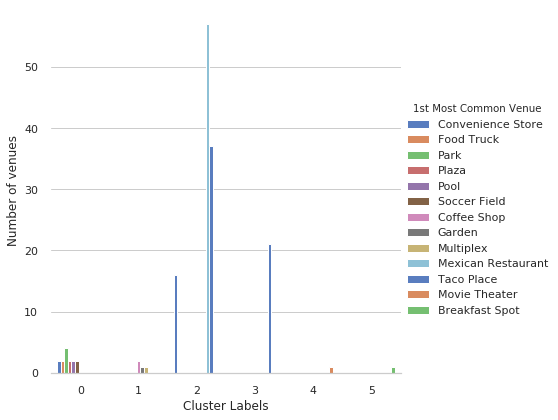

In [278]:
sns.set(style="whitegrid")
# Draw a nested barplot to show survival for class and sex
g = sns.catplot(x="Cluster Labels", y="Neighborhood", hue="1st Most Common Venue", data=b,
                height=6, kind="bar", palette="muted")
g.despine(left=True)
g.set_ylabels("Number of venues")

### Add the Clasification of the Clusters

In [279]:
df2 = pd.DataFrame(columns=['Cluster','Zone_Name'])
df2.loc[0] = pd.Series({'Cluster':0, 'Zone_Name':' Park & Convience Store'})
df2.loc[1] = pd.Series({'Cluster':1, 'Zone_Name':'Cofee Shop'})
df2.loc[2] = pd.Series({'Cluster':2, 'Zone_Name':'Mexican Restaurant and Taco Place'})
df2.loc[3] = pd.Series({'Cluster':3, 'Zone_Name':'Pure Taco Place'})
df2.loc[4] = pd.Series({'Cluster':4, 'Zone_Name':'Movie Theather'})
df2.loc[5] = pd.Series({'Cluster':5, 'Zone_Name':'Breakfast Spot'})
#df2.loc[6] = pd.Series({'Cluster':6, 'Zone_Name':'Pure Taco Place'})
#df2.loc[7] = pd.Series({'Cluster':7, 'Zone_Name':'Indie Movie Theater Zone'})
df2

,Cluster,Zone_Name
0,0,Park & Convience Store
1,1,Cofee Shop
2,2,Mexican Restaurant and Taco Place
3,3,Pure Taco Place
4,4,Movie Theather
5,5,Breakfast Spot


In [280]:
CDMX_merged= CDMX_merged.merge(df2[['Cluster', 'Zone_Name']], left_on='Cluster Labels',right_on='Cluster')
CDMX_merged.drop(['Cluster'], axis=1,inplace= True)
CDMX_merged.head()

,Neighborhood,CVE_ALC,Borough,Average_Square_Meter,Lat Center,Lon Center,Latitude,Longitude,Cluster Labels,1st Most Common Venue,...,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Type of Zone,Join,Zone_Name
0,EL PIRU (FRACC),9,ALVARO OBREGON,27751.2,19.3362,-99.2468,19.3804,-99.218,3,Taco Place,...,Pizza Place,Farmers Market,Event Service,Event Space,Exhibit,Fabric Shop,Factory,High Level HSP,"Taco Place,Wings Joint,Market",Pure Taco Place
1,SOLIDARIDAD NACIONAL,4,GUSTAVO A. MADERO,14103.5,19.5041,-99.1159,19.5343,-99.1535,3,Taco Place,...,Clothing Store,Sushi Restaurant,Big Box Store,Flea Market,Floating Market,Fish Market,Flower Shop,Bot Mid Level HSP,"Taco Place,Ice Cream Shop,Mexican Restaurant",Pure Taco Place
2,EJTO CONSTITUCIONALISTA,6,IZTAPALAPA,12117.4,19.3492,-99.0568,19.3824,-99.0484,3,Taco Place,...,Yucatecan Restaurant,Farmers Market,Event Space,Exhibit,Fabric Shop,Factory,Farm,Low Level HSP,"Taco Place,Theme Park Ride / Attraction,Park",Pure Taco Place
3,BELLAVISTA (U HAB),6,IZTAPALAPA,12117.4,19.3492,-99.0568,19.3302,-99.0711,3,Taco Place,...,Bakery,Pizza Place,BBQ Joint,Soccer Field,Athletics & Sports,Gym / Fitness Center,Yucatecan Restaurant,Low Level HSP,"Taco Place,Gym,Convenience Store",Pure Taco Place
4,ARVIDE,9,ALVARO OBREGON,27751.2,19.3362,-99.2468,19.3817,-99.2033,3,Taco Place,...,Yucatecan Restaurant,Fast Food Restaurant,Event Space,Exhibit,Fabric Shop,Factory,Farm,High Level HSP,"Taco Place,Mexican Restaurant,Garden",Pure Taco Place


In [290]:
z=w[['Borough','Average Square Meter']].groupby('Borough').mean()
z.reset_index(inplace= True)
z.rename(columns={'Average Square Meter':'Avg_Price'},inplace= True)
z.head()
#CDMX_merged.groupby('Neighborhood').mean()

,Borough,Avg_Price
0,Azcapotzalco,14603.100000
1,Benito Juárez,26767.770000
2,Coyoacán,23015.086667
3,Cuajimalpa de Morelos,29382.593333
4,Cuauhtémoc,25924.263333


We create the final choroplet map, build with the housing average price variable, and with a label form by Neighborhood, Cluster name, Type of Housing Zone Name and Top 3 venue name.

In [283]:
Mexico= r'alcaldiascdmx.json'

In [291]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10, tiles='Mapbox Bright')

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]
map_clusters.choropleth(
    geo_data=Mexico,
    data=z,
    columns=['Borough', 'Avg_Price'],
    key_on='feature.properties.nomgeo',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2)
# add markers to the map

markers_colors = []
i=0
for lat, lon, poi, cluster,house,ven,name in zip(CDMX_merged['Latitude'], CDMX_merged['Longitude'], CDMX_merged['Neighborhood'], CDMX_merged['Cluster Labels'],CDMX_merged['Type of Zone'],CDMX_merged['Join'],CDMX_merged['Zone_Name']):
    
    #i=i+1
    label = folium.Popup(str(poi) + ' / ' + str(name)+ '/'+ str(house)+ '/'+ str(ven) , parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
    #if i==6:
        #break
map_clusters

## Results and Discussion <a name="results"></a>

Our analysis shows that there are great Low-cost housing opportunities in Mexico City. At least working with our 250 Neighborhoods sample, show that the low cost Housing Price type is the most common in Mexico City. It was out of the scope of the study, but a further investigation regarding the security levels that this low-cost opportunites have will help to understand what is the best relation low-cost / security.

It was not impressive that many of the clusters have taco places and Mexican restaurant as 1st most common venue, a further analysis regarding a specific sector Coffee shop or any restaurant will be helpful for investors.

The bar chart of the Neighborhoods per each borough shows clearly that Iztapalapa a low cost Borough have more Neighborhoods compare to Miguel Hidalgo the most expensive Borough in Mexico City. 

The histogram show that there are more low cost Neighborhoods in Mexico City than expensive ones.
Finally the maps, are great tools to find out zones with the best price and the venues that the customer would like to take.

## Conclusion <a name="conclusion"></a>

The purpose of this project was to present a tool for investors and citizens in order to take real estate business decisions. The aim of this study was accomplish with the delivery of the maps. Mainly, the last map that shows in color the expensive zones, the low cost zones. Furthermore the labels of the map gives important information such as the Neighborhood name, the cluster name, the Housing type Zone and the top 3 venues.
An investor could use the map to look for the zones where restaurans, coffee shops or any business are not saturated such a look for the right zone to establish a business. Whereas, the common citizen will use the map to look for the best places to live base on the venues in the zone, the price of the zone and the vicinity to their work.